In [1]:
import pathlib
import tensorflow_docs.plots
import tensorflow_docs.modeling

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# AutoMPG Dataset

dataset_path = keras.utils.get_file("auto-mpg.data", \
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

32768/30286 [================================] - 0s 7us/step


In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names = column_names,
                      na_values = "?", comment = '\t',
                      sep=" ", skipinitialspace = True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
# check for NA rows

dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# Drop NA rows

dataset = dataset.dropna()

In [6]:
# Convert to one hot encode for country of origin 

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [7]:
dataset = pd.get_dummies(dataset, prefix = '', prefix_sep = '')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [8]:
train_dataset = dataset.sample(frac = 0.8,random_state = 42)
test_dataset = dataset.drop(train_dataset.index)

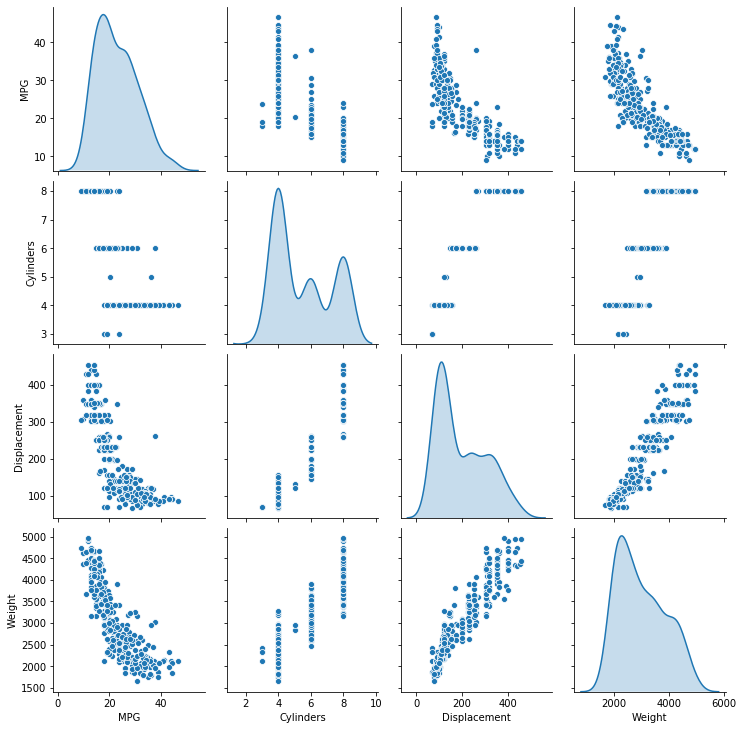

In [9]:
# Plot dataset cols

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind = "kde")

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.531847,1.729449,3.0,4.000,4.0,8.00,8.0
Displacement,314.0,197.855096,106.501896,68.0,105.000,151.0,302.00,455.0
Horsepower,314.0,105.971338,39.636557,46.0,76.000,95.0,130.00,230.0
Weight,314.0,3005.745223,859.060925,1649.0,2231.000,2831.5,3641.75,4955.0
Acceleration,314.0,15.510828,2.803560,8.0,13.625,15.5,17.00,24.8
Model Year,314.0,75.910828,3.688989,70.0,73.000,76.0,79.00,82.0
Europe,314.0,0.171975,0.377961,0.0,0.000,0.0,0.00,1.0
Japan,314.0,0.203822,0.403481,0.0,0.000,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.000,1.0,1.00,1.0


In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [12]:
# Standard Scaler

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
# Build Reg Model

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape = [len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss = 'mse',
                optimizer = optimizer,
                metrics = ['mae', 'mse'])
  return model

In [14]:
model = build_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [15]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[tfdocs.modeling.EpochDots()]) # EpochDots reduces noise when training


Epoch: 0, loss:560.6090,  mae:22.3562,  mse:560.6090,  val_loss:479.0290,  val_mae:20.4241,  val_mse:479.0290,  
....................................................................................................
Epoch: 100, loss:6.8946,  mae:1.8358,  mse:6.8946,  val_loss:5.0047,  val_mae:1.6895,  val_mse:5.0047,  
....................................................................................................
Epoch: 200, loss:6.2568,  mae:1.7331,  mse:6.2568,  val_loss:4.7380,  val_mae:1.7137,  val_mse:4.7380,  
....................................................................................................
Epoch: 300, loss:5.6498,  mae:1.6303,  mse:5.6498,  val_loss:3.8860,  val_mae:1.5412,  val_mse:3.8860,  
....................................................................................................
Epoch: 400, loss:5.1572,  mae:1.5652,  mse:5.1572,  val_loss:3.9330,  val_mae:1.5312,  val_mse:3.9330,  
..............................................................

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.553236,0.980838,2.553236,4.709698,1.740973,4.709698,995
996,2.713271,1.047767,2.713270,4.738209,1.707595,4.738210,996
997,2.743624,1.001065,2.743624,4.774779,1.675912,4.774779,997
998,2.875447,1.074890,2.875447,5.014554,1.716239,5.014555,998
999,2.569373,0.984537,2.569373,4.658446,1.726706,4.658446,999


In [17]:
# Change plots backend for a sec

plotter = tfdocs.plots.HistoryPlotter(smoothing_std = 2)

Text(0, 0.5, 'MAE [MPG]')

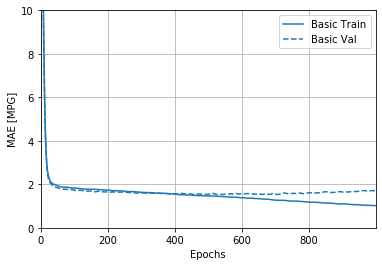

In [18]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

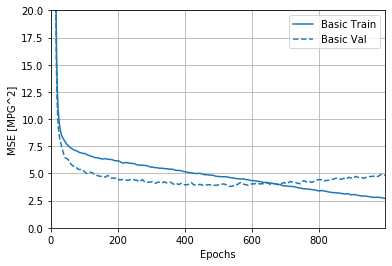

In [19]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [20]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs = EPOCHS, validation_split = 0.2, verbose = 1, 
                    callbacks = [early_stop, tfdocs.modeling.EpochDots()]) 

Train on 251 samples, validate on 63 samples
Epoch 1/1000
 32/251 [==>...........................] - ETA: 2s - loss: 644.5775 - mae: 24.3536 - mse: 644.5775
Epoch: 0, loss:595.9814,  mae:23.0159,  mse:595.9814,  val_loss:508.6809,  val_mae:21.0342,  val_mse:508.6809,  
251/251 [==============================] - 0s 2ms/sample - loss: 595.9814 - mae: 23.0159 - mse: 595.9814 - val_loss: 508.6809 - val_mae: 21.0342 - val_mse: 508.6809
Epoch 2/1000
251/251 [==============================] - 0s 213us/sample - loss: 547.9487 - mae: 21.9628 - mse: 547.9487 - val_loss: 468.7771 - val_mae: 20.0657 - val_mse: 468.7771
Epoch 3/1000
251/251 [==============================] - 0s 217us/sample - loss: 502.6416 - mae: 20.9286 - mse: 502.6416 - val_loss: 427.9499 - val_mae: 19.0277 - val_mse: 427.9499
Epoch 4/1000
251/251 [==============================] - 0s 214us/sample - loss: 453.7878 - mae: 19.7958 - mse: 453.7878 - val_loss: 382.8785 - val_mae: 17.8504 - val_mse: 382.8785
Epoch 5/1000
251/251 [===

251/251 [==============================] - 0s 200us/sample - loss: 7.9701 - mae: 2.0239 - mse: 7.9701 - val_loss: 6.1276 - val_mae: 1.8401 - val_mse: 6.1276
Epoch 47/1000
251/251 [==============================] - 0s 199us/sample - loss: 7.7123 - mae: 1.9545 - mse: 7.7123 - val_loss: 6.1364 - val_mae: 1.8184 - val_mse: 6.1364
Epoch 48/1000
251/251 [==============================] - 0s 210us/sample - loss: 7.5988 - mae: 1.9523 - mse: 7.5988 - val_loss: 5.9227 - val_mae: 1.8168 - val_mse: 5.9227
Epoch 49/1000
251/251 [==============================] - 0s 190us/sample - loss: 7.8692 - mae: 1.9663 - mse: 7.8692 - val_loss: 5.9699 - val_mae: 1.7853 - val_mse: 5.9699
Epoch 50/1000
251/251 [==============================] - 0s 211us/sample - loss: 7.5599 - mae: 1.9376 - mse: 7.5599 - val_loss: 6.0252 - val_mae: 1.8172 - val_mse: 6.0252
Epoch 51/1000
251/251 [==============================] - 0s 232us/sample - loss: 7.7172 - mae: 1.9670 - mse: 7.7172 - val_loss: 5.7708 - val_mae: 1.7592 - val_

Text(0, 0.5, 'MAE [MPG]')

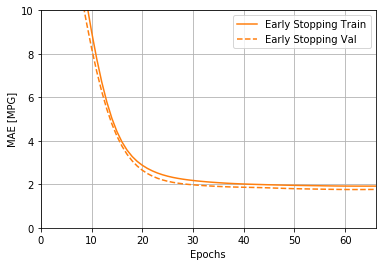

In [21]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [22]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose = 2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 8.3093 - mae: 2.0940 - mse: 8.3093
Testing set Mean Abs Error:  2.09 MPG


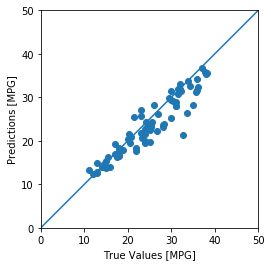

In [23]:
# Predict on dataset

test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

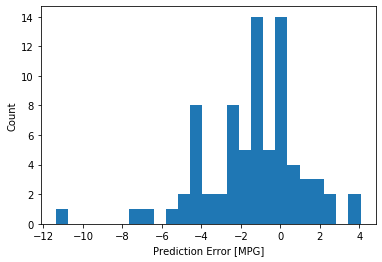

In [24]:
# Error Distribution

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")